In [2]:
#imports
import numpy as np
import pandas as pd 
import glob
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import svm
import csv
from sklearn.linear_model import LinearRegression
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from copulas.multivariate import GaussianMultivariate
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics 
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import time
import datetime
import matplotlib.ticker as plticker
import matplotlib.patches as mpatches
from statsmodels.tsa.arima.model import ARIMA

In [3]:
#dataframes

#the training set. Daily historical data from January 2013 to October 2015
df_train = pd.read_csv('sales_train.csv')
#You need to forecast the sales for these shops and products for November 2015.
df_test = pd.read_csv('test.csv')
#supplemental information about the items/products.
df_items = pd.read_csv('items.csv')
#supplemental information about the items categories.
df_categories = pd.read_csv('item_categories.csv')
#supplemental information about the shops.
df_shops = pd.read_csv('shops.csv')

#combine the train and test set + suplementaries into a single dataset
df_traintest = pd.merge(df_test, df_train)
df_itemcategories = pd.merge(df_items,df_categories)
df_traintestshops = pd.merge(df_traintest, df_shops)
#the combined dataset
df = pd.merge(df_traintestshops,df_itemcategories)
df.to_csv(r'df.csv', index = 'date', header=True)
#Data fields
#ID - an Id that represents a (Shop, Item) tuple within the test set
#shop_id - unique identifier of a shop
#item_id - unique identifier of a product
#item_category_id - unique identifier of item category
#item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
#item_price - current price of an item
#date - date in format dd/mm/yyyy
#date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
#item_name - name of item
#shop_name - name of shop
#item_category_name - name of item category


## Predict total sales for every product and store in the next month.
The y data we're interested in for training the model would be the item_cnt_day
the X data would be the date, and suplementary data previously combined into a composite csv file

In [46]:
#**********Set the monthly item count***********************
#every unique combination of shops and items

df_predictOnThis = pd.DataFrame()
#the item/shop pair further divided into date blocks
grouped_df = df.groupby(['shop_id','item_id','date_block_num'])
dict = {}
#for every dateblock in our shop/item pairing, set the monthly item count
i = 0
for index, group in grouped_df:
    #iterate through every shop item combination
    if(i % 1000 == 0):
        print("iteration no. ", i)
    i += 1
    df_n=group
    df_n['monthly_item_cnt'] = df_n['item_cnt_day'].sum()
    monthitemcnt = df_n.iloc[-1]['monthly_item_cnt']
    #take group size into acount, 
    dict[i] = {'ID': int(df_n['ID'].values[0]),
               'shop_id':int(df_n['shop_id'].values[0]),
               'item_id':int(df_n['item_id'].values[0]),
               'date_block_num':int(df_n['date_block_num'].values[0]),
               'item_price':int(df_n['item_price'].values[0]),
               'item_cnt_day':int(df_n['item_cnt_day'].values[0]),
               'item_category_id':int(df_n['item_category_id'].values[0]),
               'monthly_item_cnt':monthitemcnt}
print("Finished compilation")
df_predictOnThis = pd.DataFrame.from_dict(dict,'index')
#NOTE: do not recompile unless you have excess time to spare

iteration no.  0
iteration no.  1000
iteration no.  2000
iteration no.  3000
iteration no.  4000
iteration no.  5000
iteration no.  6000
iteration no.  7000
iteration no.  8000
iteration no.  9000
iteration no.  10000
iteration no.  11000
iteration no.  12000
iteration no.  13000
iteration no.  14000
iteration no.  15000
iteration no.  16000
iteration no.  17000
iteration no.  18000
iteration no.  19000
iteration no.  20000
iteration no.  21000
iteration no.  22000
iteration no.  23000
iteration no.  24000
iteration no.  25000
iteration no.  26000
iteration no.  27000
iteration no.  28000
iteration no.  29000
iteration no.  30000
iteration no.  31000
iteration no.  32000
iteration no.  33000
iteration no.  34000
iteration no.  35000
iteration no.  36000
iteration no.  37000
iteration no.  38000
iteration no.  39000
iteration no.  40000
iteration no.  41000
iteration no.  42000
iteration no.  43000
iteration no.  44000
iteration no.  45000
iteration no.  46000
iteration no.  47000
itera

iteration no.  378000
iteration no.  379000
iteration no.  380000
iteration no.  381000
iteration no.  382000
iteration no.  383000
iteration no.  384000
iteration no.  385000
iteration no.  386000
iteration no.  387000
iteration no.  388000
iteration no.  389000
iteration no.  390000
iteration no.  391000
iteration no.  392000
iteration no.  393000
iteration no.  394000
iteration no.  395000
iteration no.  396000
iteration no.  397000
iteration no.  398000
iteration no.  399000
iteration no.  400000
iteration no.  401000
iteration no.  402000
iteration no.  403000
iteration no.  404000
iteration no.  405000
iteration no.  406000
iteration no.  407000
iteration no.  408000
iteration no.  409000
iteration no.  410000
iteration no.  411000
iteration no.  412000
iteration no.  413000
iteration no.  414000
iteration no.  415000
iteration no.  416000
iteration no.  417000
iteration no.  418000
iteration no.  419000
iteration no.  420000
iteration no.  421000
iteration no.  422000
iteration 

In [49]:
df_predictOnThis.to_csv(r'df_predictonthis.csv', index = False, header=True)
print("compilation complete")

compilation complete


In [63]:
import warnings
warnings.filterwarnings('ignore')
#****************WHERE THE MAGIC HAPPENS***********************
#create dummies for the test and training set (df_n is the current training set)
#create synthetic data to insert as X
def create_synthetic():
    """
    Modelled using a Gaussian copula, it generates a synthetic X dataset. It
    returns the new, synthetic versions of X.
    """
    dataset = pd.concat([pd.to_datetime(df_n['date']).map(dt.datetime.toordinal),
                            df_n['date_block_num'],
                            df_n['shop_id'],
                            df_n['item_id'],
                            df_n['item_price'],
                            df_n['item_category_id'],
                            df_n['item_cnt_day']], 1)

    model = GaussianMultivariate()
    model.fit(dataset)

    synthetic = model.sample(len(dataset))

    dataset = synthetic.values

    return dataset

def predict_new_row(k):
    dataset = pd.DataFrame()
    pred_y = pd.DataFrame()
    pred_X = pd.DataFrame()
    #for every column of data in X
    for index, column in k.iteritems():
        #this is our y
        pred_y=column
        #these are our X
        pred_X = k
        pred_X = pred_X.drop(index, axis=1)
        #no point in splitting into train/test sets as there is only one sample
        X_train, X_test, y_train, y_test = train_test_split(pred_X,pred_y)
        
        #Fit a model on these new data
        
        #Random Forest
        model = RandomForestRegressor()

        #Fit the model using the whole data set
        model.fit(pred_X,pred_y)
        #pred_X = preprocessing.scale(pred_X)
        #some scoring 
        #print("coefficient of determination:",  model.score(pred_X,pred_y))
        #the predict is the new variable for this column in the new X dataframe
        X_predict = model.predict(pred_X)
        dataset[index] = X_predict
    #Return the new, predicted X
    return dataset

dict = {}
df_predict = pd.read_csv('df_predictonthis.csv')

grouped_df = df_predict.groupby(['shop_id','item_id'])
k = 0
print(len(grouped_df))
#Go through all the shop/item pairings
for index, group in grouped_df:
    if(k % 100 == 0):
        print("iteration no.",k)
    k += 1
    #Random Forest
    model = RandomForestRegressor()
   #the current shop item combination
    #df_n= grouped_df.get_group((row['shop_id'],row['item_id']))
    #the row we want to predict
    y = group['monthly_item_cnt']
    #our independent variables
    X = group.drop(['monthly_item_cnt'], axis = 1 )
    
    numIter = int(X.iloc[-1]['date_block_num'])
    ID = int(group.iloc[-1]['ID'])
    
    #Divide the data set into training data and testing data
   #if there's enough samples to split, else just use X and y
    size = len(group.index)
    if  size > 1:
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)
        
        X_train = preprocessing.scale(X_train)
        #Fit the model using training data
        model.fit(X_train, y_train)

    #Fit the model again using the whole data set
    X = preprocessing.scale(X)
    model.fit(X,y)
    #predict the unseen data
    predict = model.predict(X)
    #print("MSE: %.4f" % mse)
    #print("unseen data:", predict)
    #next months value casted to int, our desired number
    #print("forecast for next month: ", int(predict))


    #If the data ends on a date block that isn't 33, we need to do predictions on the 
    #prediction we get 
    #NEXT: take the y prediction and make that your new y
    #fit it onto a new model
    #the final predict on that prediction is your following month
    #Do this for every month block until you reach 34
    if numIter != 33:
        for j in range(34 - numIter):   
            monthModel = RandomForestRegressor()
            group['monthly_item_cnt'] = predict
            month_y = group['monthly_item_cnt']
            month_X = X
            
            #Divide the data set into training data and testing data
            if  size > 1:
                X_train, X_test, y_train, 
                y_test = train_test_split(month_X,month_y,test_size = 0.2)

                X_train = preprocessing.scale(X_train)
                #Fit the model using training data
                monthModel.fit(X_train, y_train)
                
            #Fit the model again using the whole data set
            monthModel.fit(month_X,month_y)
            month_X = preprocessing.scale(month_X)
            #some scoring 
            predict = monthModel.predict(month_X)
            #our desired value, casted to int for convenience
            item_cnt_next_month = int(predict[-1])
            #export to submission file            
        dict[k] = {'ID': ID,'item_cnt_month':item_cnt_next_month}
    else:
        item_cnt_next_month = int(predict[-1]) 
        #export to submission file
        dict[k] = {'ID': ID,'item_cnt_month':item_cnt_next_month}
df_submission = pd.DataFrame.from_dict(dict,'index')
df_submission.to_csv(r'submissionFile.csv', index = False, header=True)    
print("finished compiling")



111404
iteration no. 0
iteration no. 100
iteration no. 200
iteration no. 300
iteration no. 400
iteration no. 500
iteration no. 600
iteration no. 700
iteration no. 800
iteration no. 900
iteration no. 1000
iteration no. 1100
iteration no. 1200
iteration no. 1300
iteration no. 1400
iteration no. 1500
iteration no. 1600
iteration no. 1700
iteration no. 1800
iteration no. 1900
iteration no. 2000
iteration no. 2100
iteration no. 2200
iteration no. 2300
iteration no. 2400
iteration no. 2500
iteration no. 2600
iteration no. 2700
iteration no. 2800
iteration no. 2900
iteration no. 3000
iteration no. 3100
iteration no. 3200
iteration no. 3300
iteration no. 3400
iteration no. 3500
iteration no. 3600
iteration no. 3700
iteration no. 3800
iteration no. 3900
iteration no. 4000
iteration no. 4100
iteration no. 4200
iteration no. 4300
iteration no. 4400
iteration no. 4500
iteration no. 4600
iteration no. 4700
iteration no. 4800
iteration no. 4900
iteration no. 5000
iteration no. 5100
iteration no. 520

iteration no. 41500
iteration no. 41600
iteration no. 41700
iteration no. 41800
iteration no. 41900
iteration no. 42000
iteration no. 42100
iteration no. 42200
iteration no. 42300
iteration no. 42400
iteration no. 42500
iteration no. 42600
iteration no. 42700
iteration no. 42800
iteration no. 42900
iteration no. 43000
iteration no. 43100
iteration no. 43200
iteration no. 43300
iteration no. 43400
iteration no. 43500
iteration no. 43600
iteration no. 43700
iteration no. 43800
iteration no. 43900
iteration no. 44000
iteration no. 44100
iteration no. 44200
iteration no. 44300
iteration no. 44400
iteration no. 44500
iteration no. 44600
iteration no. 44700
iteration no. 44800
iteration no. 44900
iteration no. 45000
iteration no. 45100
iteration no. 45200
iteration no. 45300
iteration no. 45400
iteration no. 45500
iteration no. 45600
iteration no. 45700
iteration no. 45800
iteration no. 45900
iteration no. 46000
iteration no. 46100
iteration no. 46200
iteration no. 46300
iteration no. 46400


iteration no. 82500
iteration no. 82600
iteration no. 82700
iteration no. 82800
iteration no. 82900
iteration no. 83000
iteration no. 83100
iteration no. 83200
iteration no. 83300
iteration no. 83400
iteration no. 83500
iteration no. 83600
iteration no. 83700
iteration no. 83800
iteration no. 83900
iteration no. 84000
iteration no. 84100
iteration no. 84200
iteration no. 84300
iteration no. 84400
iteration no. 84500
iteration no. 84600
iteration no. 84700
iteration no. 84800
iteration no. 84900
iteration no. 85000
iteration no. 85100
iteration no. 85200
iteration no. 85300
iteration no. 85400
iteration no. 85500
iteration no. 85600
iteration no. 85700
iteration no. 85800
iteration no. 85900
iteration no. 86000
iteration no. 86100
iteration no. 86200
iteration no. 86300
iteration no. 86400
iteration no. 86500
iteration no. 86600
iteration no. 86700
iteration no. 86800
iteration no. 86900
iteration no. 87000
iteration no. 87100
iteration no. 87200
iteration no. 87300
iteration no. 87400


In [66]:
#sort the file by ID
df = pd.read_csv('submissionFile.csv')
sorted_df = df.sort_values(by=['ID'], ascending=True)
sorted_df.to_csv('submissionFile_sorted.csv', index=False)

R2 score: 0.7767999999999999
MSE: 0.1047
unseen data: [1.1  1.22 1.88 1.92 1.02 1.08 1.12 2.14 1.32]
real data:
 31802    1.0
31803    1.0
31804    2.0
31805    2.0
31806    1.0
31807    1.0
31808    1.0
31809    3.0
31810    1.0
Name: monthly_item_cnt, dtype: float64
forecast:
 31802    1.10
31803    1.22
31804    1.88
31805    1.92
31806    1.02
31807    1.08
31808    1.12
31809    2.14
31810    1.32
Name: forecast, dtype: float64


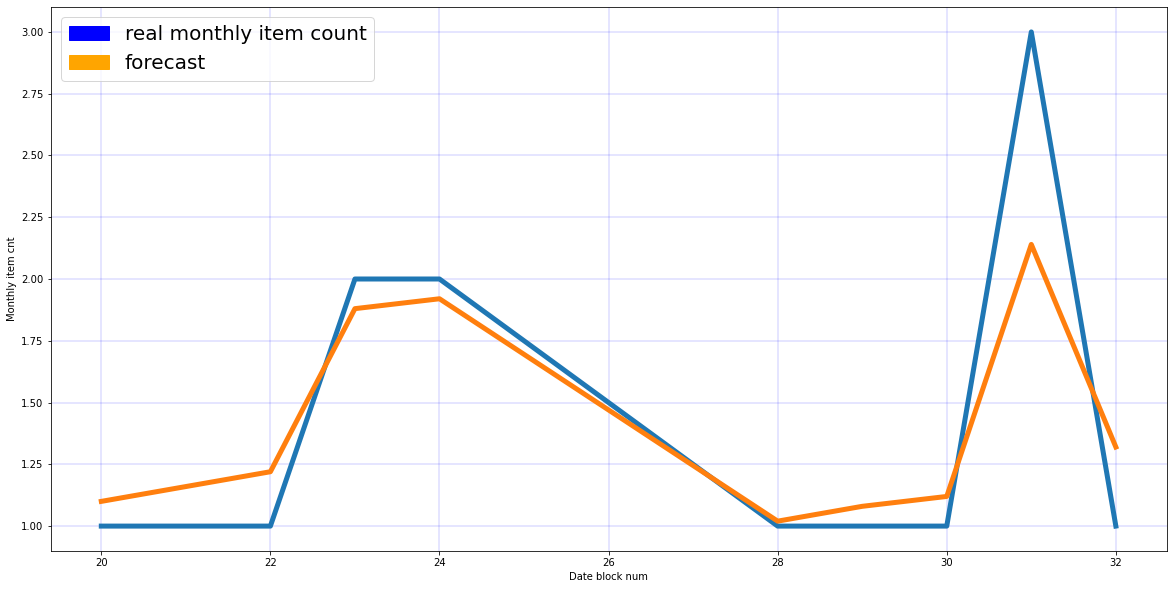

In [155]:
model = RandomForestRegressor()
#the current shop item combination
group = grouped_df.get_group((5,5037))
#the row we want to predict
y = group['monthly_item_cnt']
#our independent variables
X = group.drop(['monthly_item_cnt'], axis = 1)

#Divide the data set into training data and testing data
#if there's enough samples to split, else just use X and y
size = len(group.index)
if  size > 1:
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

    X_train = preprocessing.scale(X_train)
    #Fit the model using training data
    model.fit(X_train, y_train)
#Fit the model again using the whole data set
X = preprocessing.scale(X)
model.fit(X,y)
score = model.score(X, y)
#predict the unseen data
predict = model.predict(X)
mse = mean_squared_error(y, predict)
print("R2 score:", score)
print("MSE: %.4f" % mse)
print("unseen data:", predict)

    
    
df_real = group
forecast = group
forecast['forecast'] = predict
#next months' values
print("real data:\n", df_real['monthly_item_cnt'])
print ("forecast:\n", forecast['forecast'])
plt.figure(figsize=(20,10))
original_line = plt.plot(df_real['date_block_num'],df_real['monthly_item_cnt'], linewidth=5)
forecast_line = plt.plot(forecast['date_block_num'],forecast['forecast'], linewidth=5)
plt.xlabel('Date block num')
plt.ylabel('Monthly item cnt')

blue_patch = mpatches.Patch(color='blue', label='real monthly item count')
orange_patch = mpatches.Patch(color='orange', label='forecast')
plt.legend(handles=[blue_patch,orange_patch], prop={'size':20})
plt.grid(color='b', linestyle='-', linewidth=0.2)
plt.show()

R2 score: 0.08392418606581797
MSE: 0.4298
unseen data: [1.3280009  1.58313042 1.20259094 1.33015571 1.24762648 1.54455932
 1.67212408 1.79968885 1.29212331]
real data: 31802    1.0
31803    1.0
31804    2.0
31805    2.0
31806    1.0
31807    1.0
31808    1.0
31809    3.0
31810    1.0
Name: monthly_item_cnt, dtype: float64
forecast: 31802    1.328001
31803    1.583130
31804    1.202591
31805    1.330156
31806    1.247626
31807    1.544559
31808    1.672124
31809    1.799689
31810    1.292123
Name: forecast, dtype: float64


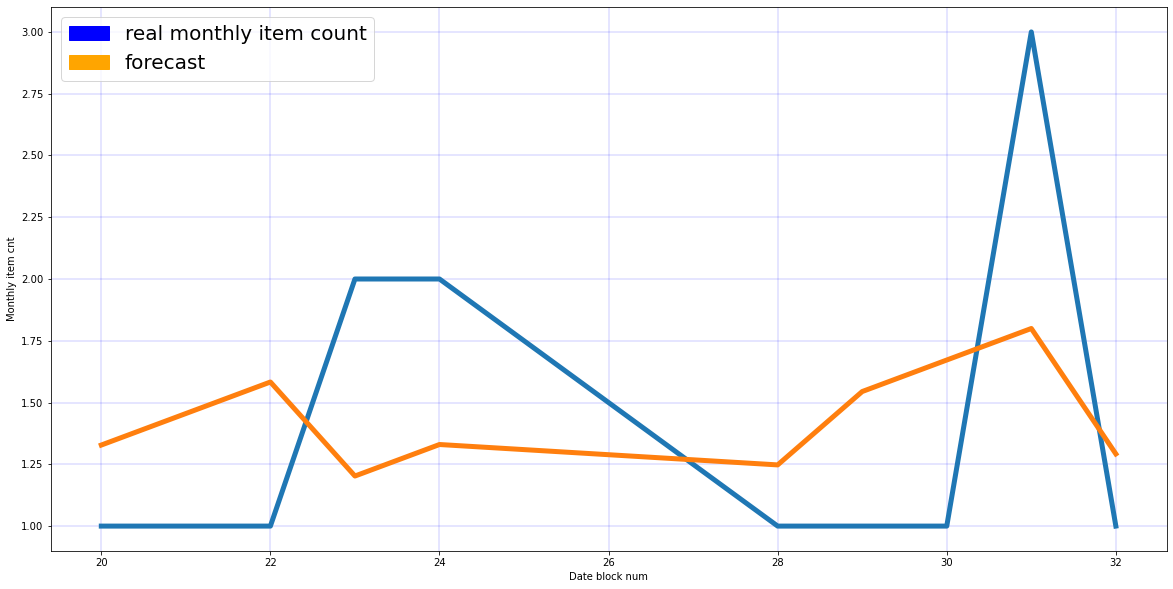

In [153]:
#Linear Regression

model = LinearRegression()

#the current shop item combination
group = grouped_df.get_group((5,5037))
#the row we want to predict
y = group['monthly_item_cnt']
#our independent variables
X = group.drop(['monthly_item_cnt'], axis = 1)

#Divide the data set into training data and testing data
#if there's enough samples to split, else just use X and y
size = len(group.index)
if  size > 1:
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

    X_train = preprocessing.scale(X_train)
    #Fit the model using training data
    model.fit(X_train, y_train)
#Fit the model again using the whole data set
X = preprocessing.scale(X)
model.fit(X,y)
score = model.score(X, y)
#predict the unseen data
predict = model.predict(X)
mse = mean_squared_error(y, predict)
print("R2 score:", score)
print("MSE: %.4f" % mse)
print("unseen data:", predict)

    
    
df_real = group
forecast = group
forecast['forecast'] = predict
#next months' values
print("real data:", df_real['monthly_item_cnt'])
print ("forecast:", forecast['forecast'])
plt.figure(figsize=(20,10))
original_line = plt.plot(df_real['date_block_num'],df_real['monthly_item_cnt'], linewidth=5)
forecast_line = plt.plot(forecast['date_block_num'],forecast['forecast'], linewidth=5)
plt.xlabel('Date block num')
plt.ylabel('Monthly item cnt')

blue_patch = mpatches.Patch(color='blue', label='real monthly item count')
orange_patch = mpatches.Patch(color='orange', label='forecast')
plt.legend(handles=[blue_patch,orange_patch], prop={'size':20})
plt.grid(color='b', linestyle='-', linewidth=0.2)
plt.show()




R2 score: 0.6666666666666666
MSE: 0.6667
unseen data: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
real data: 31802    1.0
31803    1.0
31804    2.0
31805    2.0
31806    1.0
31807    1.0
31808    1.0
31809    3.0
31810    1.0
Name: monthly_item_cnt, dtype: float64
forecast: 31802    1.0
31803    1.0
31804    1.0
31805    1.0
31806    1.0
31807    1.0
31808    1.0
31809    1.0
31810    1.0
Name: forecast, dtype: float64


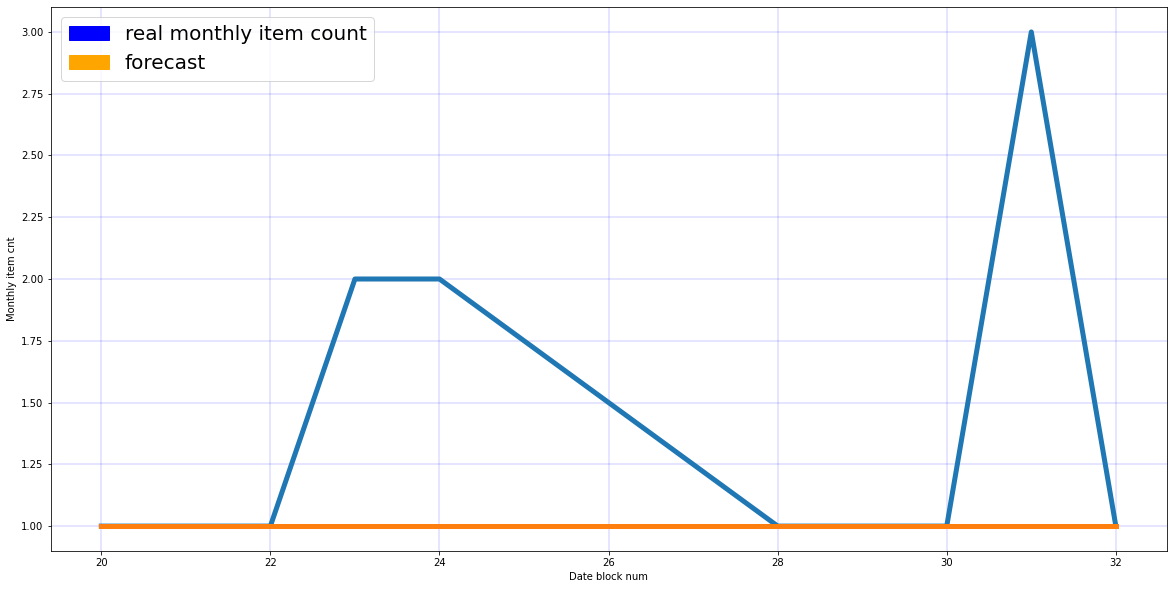

Confusion matrix evaluating the quality of the output
The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.


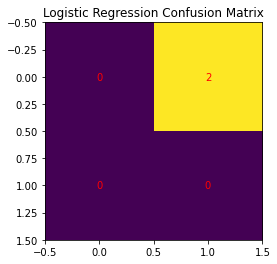

Normalization helps visualize and pinpoint class imbalance, and which classes are being misclassified


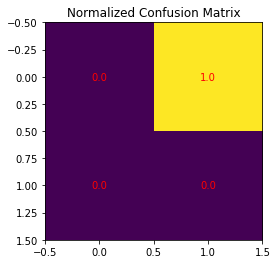

              precision    recall  f1-score   support

         1.0       0.67      1.00      0.80         6
         2.0       0.00      0.00      0.00         2
         3.0       0.00      0.00      0.00         1

    accuracy                           0.67         9
   macro avg       0.22      0.33      0.27         9
weighted avg       0.44      0.67      0.53         9

(2,)
(2,)


In [161]:
model = LogisticRegression()

#the current shop item combination
group = grouped_df.get_group((5,5037))
#the row we want to predict
y = group['monthly_item_cnt']
#our independent variables
X = group.drop(['monthly_item_cnt'], axis = 1)

#Divide the data set into training data and testing data
#if there's enough samples to split, else just use X and y
size = len(group.index)
if  size > 1:
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

    X_train = preprocessing.scale(X_train)
    #Fit the model using training data
    model.fit(X_train, y_train)
#Fit the model again using the whole data set
X = preprocessing.scale(X)
model.fit(X,y)
score = model.score(X, y)
#predict the unseen data
predict = model.predict(X)
mse = mean_squared_error(y, predict)
print("R2 score:", score)
print("MSE: %.4f" % mse)
print("unseen data:", predict)

    
    
df_real = group
forecast = group
forecast['forecast'] = predict
#next months' values
print("real data:", df_real['monthly_item_cnt'])
print ("forecast:", forecast['forecast'])
plt.figure(figsize=(20,10))
original_line = plt.plot(df_real['date_block_num'],df_real['monthly_item_cnt'], linewidth=5)
forecast_line = plt.plot(forecast['date_block_num'],forecast['forecast'], linewidth=5)
plt.xlabel('Date block num')
plt.ylabel('Monthly item cnt')

blue_patch = mpatches.Patch(color='blue', label='real monthly item count')
orange_patch = mpatches.Patch(color='orange', label='forecast')
plt.legend(handles=[blue_patch,orange_patch], prop={'size':20})
plt.grid(color='b', linestyle='-', linewidth=0.2)
plt.show()



#Confusion matrix
cm = metrics.confusion_matrix(y_test, model.predict(X_test))
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
        ax.set_title("Logistic Regression Confusion Matrix")
print("Confusion matrix evaluating the quality of the output")
print("The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.")
plt.show()

#normalized confusion matrix

cm = metrics.confusion_matrix(y_test, model.predict(X_test), normalize='true')
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
        ax.set_title("Normalized Confusion Matrix")
print("Normalization helps visualize and pinpoint class imbalance, and which classes are being misclassified")
plt.show()
print(metrics.classification_report(y ,predict))
print(model.predict(X_test).shape)
print(y_test.shape)




R2 score: 0.6666666666666666
MSE: 0.6667
unseen data: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
real data: 31802    1.0
31803    1.0
31804    2.0
31805    2.0
31806    1.0
31807    1.0
31808    1.0
31809    3.0
31810    1.0
Name: monthly_item_cnt, dtype: float64
forecast: 31802    1.0
31803    1.0
31804    1.0
31805    1.0
31806    1.0
31807    1.0
31808    1.0
31809    1.0
31810    1.0
Name: forecast, dtype: float64


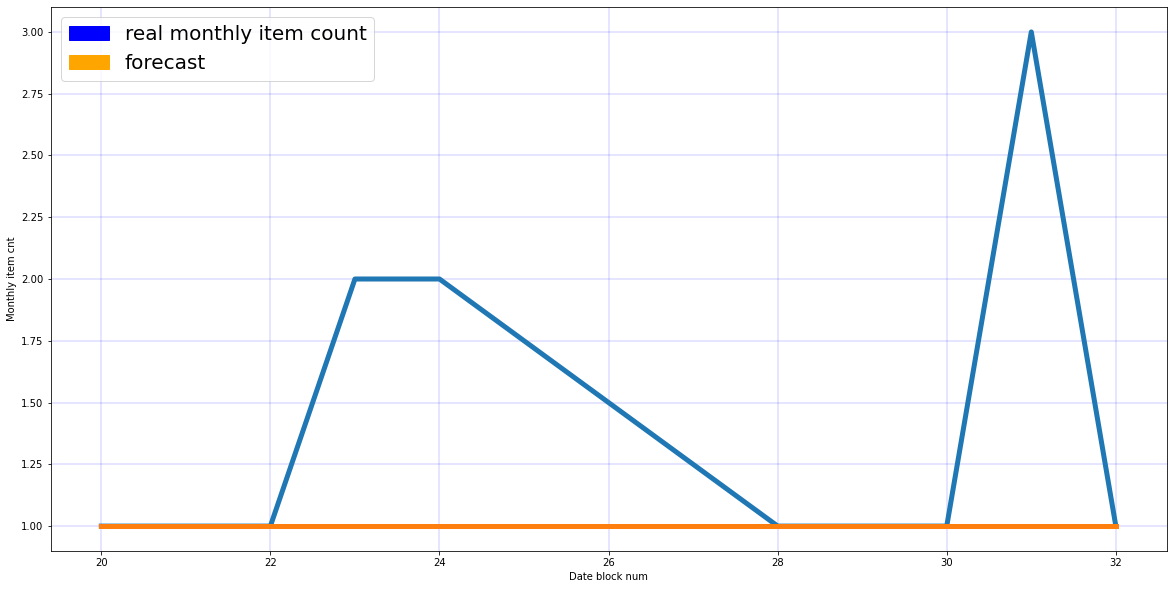

Confusion matrix evaluating the quality of the output
The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.


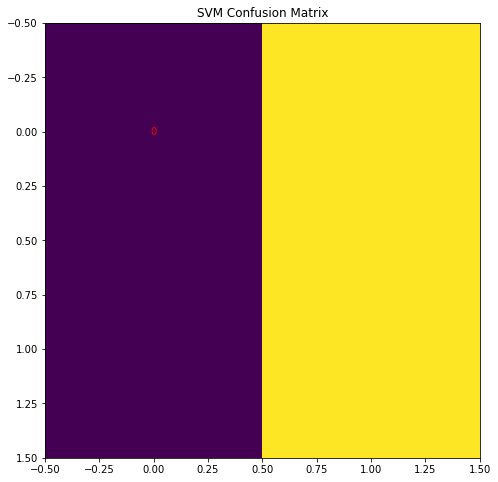

Normalization helps visualize and pinpoint class imbalance, and which classes are being misclassified


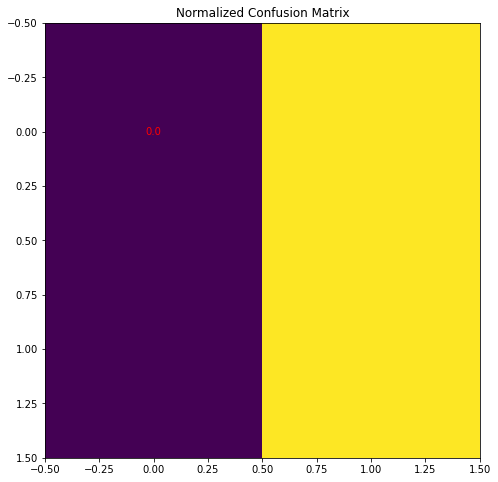

              precision    recall  f1-score   support

         1.0       0.67      1.00      0.80         6
         2.0       0.00      0.00      0.00         2
         3.0       0.00      0.00      0.00         1

    accuracy                           0.67         9
   macro avg       0.22      0.33      0.27         9
weighted avg       0.44      0.67      0.53         9

(2,)
(2,)


In [160]:
model = svm.SVC(kernel='poly', C=1.0, max_iter=1000)

#the current shop item combination
group = grouped_df.get_group((5,5037))
#the row we want to predict
y = group['monthly_item_cnt']
#our independent variables
X = group.drop(['monthly_item_cnt'], axis = 1)

#Divide the data set into training data and testing data
#if there's enough samples to split, else just use X and y
size = len(group.index)
if  size > 1:
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

    X_train = preprocessing.scale(X_train)
    #Fit the model using training data
    model.fit(X_train, y_train)
#Fit the model again using the whole data set
X = preprocessing.scale(X)
model.fit(X,y)
score = model.score(X, y)
#predict the unseen data
predict = model.predict(X)
mse = mean_squared_error(y, predict)
print("R2 score:", score)
print("MSE: %.4f" % mse)
print("unseen data:", predict)

    
    
df_real = group
forecast = group
forecast['forecast'] = predict
#next months' values
print("real data:", df_real['monthly_item_cnt'])
print ("forecast:", forecast['forecast'])
plt.figure(figsize=(20,10))
original_line = plt.plot(df_real['date_block_num'],df_real['monthly_item_cnt'], linewidth=5)
forecast_line = plt.plot(forecast['date_block_num'],forecast['forecast'], linewidth=5)
plt.xlabel('Date block num')
plt.ylabel('Monthly item cnt')

blue_patch = mpatches.Patch(color='blue', label='real monthly item count')
orange_patch = mpatches.Patch(color='orange', label='forecast')
plt.legend(handles=[blue_patch,orange_patch], prop={'size':20})
plt.grid(color='b', linestyle='-', linewidth=0.2)
plt.show()


#Confusion matrix
cm = metrics.confusion_matrix(y_test, model.predict(X_test))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
for i in range(1):
    for j in range(1):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
        ax.set_title("SVM Confusion Matrix")
print("Confusion matrix evaluating the quality of the output")
print("The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.")
plt.show()

#normalized confusion matrix

cm = metrics.confusion_matrix(y_test, model.predict(X_test), normalize='true')
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
for i in range(1):
    for j in range(1):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
        ax.set_title("Normalized Confusion Matrix")
print("Normalization helps visualize and pinpoint class imbalance, and which classes are being misclassified")
plt.show()
print(metrics.classification_report(y ,predict))
print(model.predict(X_test).shape)
print(y_test.shape)



R2 score: 1.0
MSE: 0.0000
unseen data: [1. 1. 2. 2. 1. 1. 1. 3. 1.]
real data: 31802    1.0
31803    1.0
31804    2.0
31805    2.0
31806    1.0
31807    1.0
31808    1.0
31809    3.0
31810    1.0
Name: monthly_item_cnt, dtype: float64
forecast: 31802    1.0
31803    1.0
31804    2.0
31805    2.0
31806    1.0
31807    1.0
31808    1.0
31809    3.0
31810    1.0
Name: forecast, dtype: float64


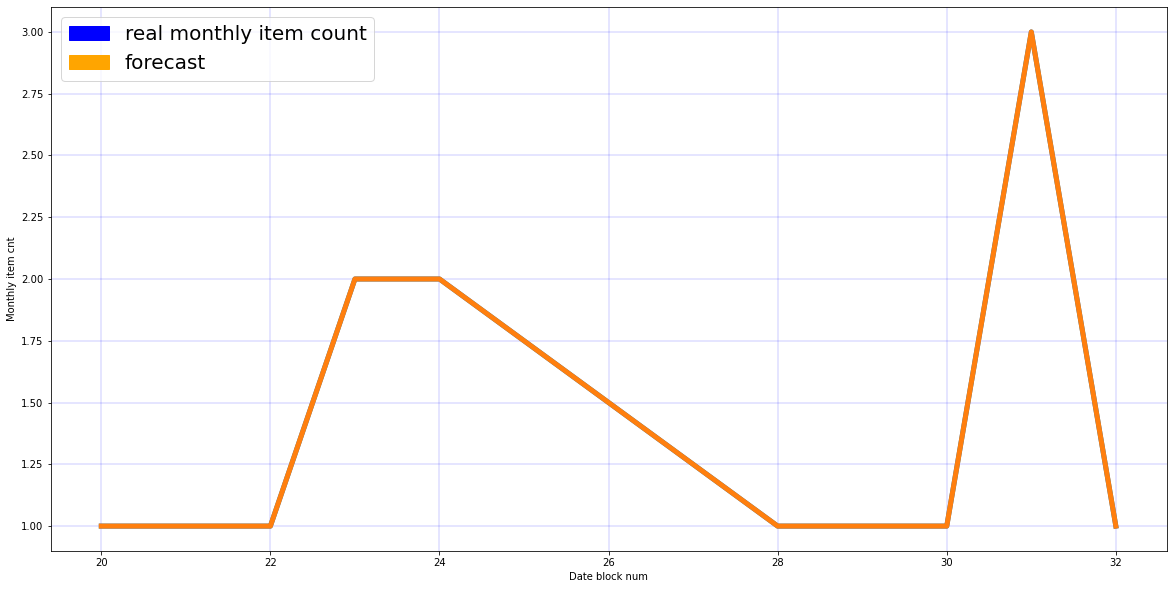

Confusion matrix evaluating the quality of the output
The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.


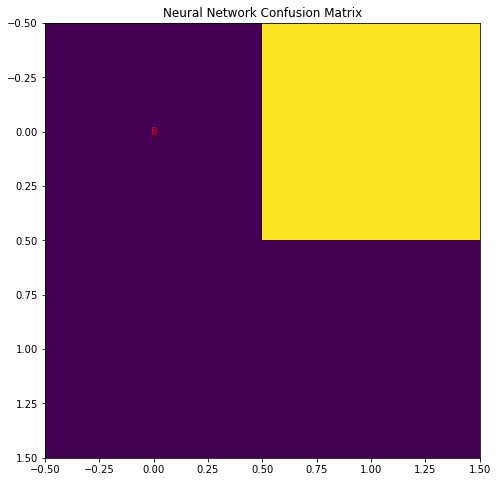

Normalization helps visualize and pinpoint class imbalance, and which classes are being misclassified


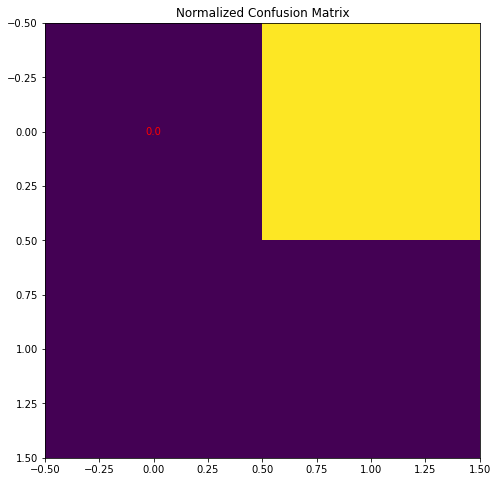

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         6
         2.0       1.00      1.00      1.00         2
         3.0       1.00      1.00      1.00         1

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

(2,)
(2,)


In [162]:
model = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam',max_iter=10000)
#the current shop item combination
group = grouped_df.get_group((5,5037))
#the row we want to predict
y = group['monthly_item_cnt']
#our independent variables
X = group.drop(['monthly_item_cnt'], axis = 1)

#Divide the data set into training data and testing data
#if there's enough samples to split, else just use X and y
size = len(group.index)
if  size > 1:
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

    X_train = preprocessing.scale(X_train)
    #Fit the model using training data
    model.fit(X_train, y_train)
#Fit the model again using the whole data set
X = preprocessing.scale(X)
model.fit(X,y)
score = model.score(X, y)
#predict the unseen data
predict = model.predict(X)
mse = mean_squared_error(y, predict)
print("R2 score:", score)
print("MSE: %.4f" % mse)
print("unseen data:", predict)

    
    
df_real = group
forecast = group
forecast['forecast'] = predict
#next months' values
print("real data:", df_real['monthly_item_cnt'])
print ("forecast:", forecast['forecast'])
plt.figure(figsize=(20,10))
original_line = plt.plot(df_real['date_block_num'],df_real['monthly_item_cnt'], linewidth=5)
forecast_line = plt.plot(forecast['date_block_num'],forecast['forecast'], linewidth=5)
plt.xlabel('Date block num')
plt.ylabel('Monthly item cnt')

blue_patch = mpatches.Patch(color='blue', label='real monthly item count')
orange_patch = mpatches.Patch(color='orange', label='forecast')
plt.legend(handles=[blue_patch,orange_patch], prop={'size':20})
plt.grid(color='b', linestyle='-', linewidth=0.2)
plt.show()


#Confusion matrix
cm = metrics.confusion_matrix(y_test, model.predict(X_test))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
for i in range(1):
    for j in range(1):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
        ax.set_title("Neural Network Confusion Matrix")
print("Confusion matrix evaluating the quality of the output")
print("The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.")
plt.show()

#normalized confusion matrix

cm = metrics.confusion_matrix(y_test, model.predict(X_test), normalize='true')
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
for i in range(1):
    for j in range(1):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
        ax.set_title("Normalized Confusion Matrix")
print("Normalization helps visualize and pinpoint class imbalance, and which classes are being misclassified")
plt.show()
print(metrics.classification_report(y ,predict))
print(model.predict(X_test).shape)
print(y_test.shape)
